In [1]:
from binance.client import Client as bnb_client
from datetime import datetime
import pandas as pd

client = bnb_client()  # if you're in the US, please use: client=bnb_client(tld='US')

# Function to format the data
def format_binance(data):
    columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_volume',
               'num_trades', 'taker_base_volume', 'taker_quote_volume', 'ignore']

    data = pd.DataFrame(data, columns=columns)

    # Convert from POSIX timestamp (milliseconds since Jan 1, 1970)
    data['open_time'] = data['open_time'].map(lambda x: datetime.fromtimestamp(x / 1000))
    data['close_time'] = data['close_time'].map(lambda x: datetime.fromtimestamp(x / 1000))
    
    # Ensure close prices are numeric
    data['close'] = pd.to_numeric(data['close'], errors='coerce')
    
    return data

# Fetch historical data for BTCUSDT and ETHUSDT
btc_px = format_binance(client.get_historical_klines('BTCUSDT', '1d', '2018-12-15'))
eth_px = format_binance(client.get_historical_klines('ETHUSDT', '1d', '2018-12-15'))

# Merge both dataframes on 'open_time'
combined_df = pd.merge(btc_px[['open_time', 'close']], eth_px[['open_time', 'close']], on='open_time', suffixes=('_BTC', '_ETH'))

# Set 'open_time' as the index
combined_df.set_index('open_time', inplace=True)

print(combined_df)

                     close_BTC  close_ETH
open_time                                
2018-12-15 08:00:00    3211.72      83.76
2018-12-16 08:00:00    3228.67      84.67
2018-12-17 08:00:00    3509.08      94.02
2018-12-18 08:00:00    3652.98     100.39
2018-12-19 08:00:00    3662.22      98.74
...                        ...        ...
2024-12-17 08:00:00  106133.74    3893.01
2024-12-18 08:00:00  100204.01    3626.80
2024-12-19 08:00:00   97461.86    3417.01
2024-12-20 08:00:00   97805.44    3472.21
2024-12-21 08:00:00   97248.00    3385.80

[2199 rows x 2 columns]


In [2]:
# Convert 'close_BTC' and 'close_ETH' to numeric values
combined_df['close_BTC'] = pd.to_numeric(combined_df['close_BTC'], errors='coerce')
combined_df['close_ETH'] = pd.to_numeric(combined_df['close_ETH'], errors='coerce')

# Calculate the daily returns for both BTC and ETH
combined_df['return_BTC'] = combined_df['close_BTC'] / combined_df['close_BTC'].shift(1) - 1
combined_df['return_ETH'] = combined_df['close_ETH'] / combined_df['close_ETH'].shift(1) - 1

# Calculate the rolling 30-day volatility (standard deviation of daily returns)
combined_df['volatility_BTC'] = combined_df['return_BTC'].rolling(window=30).std() * (252 ** 0.5)  # Annualize volatility
combined_df['volatility_ETH'] = combined_df['return_ETH'].rolling(window=30).std() * (252 ** 0.5)

print(combined_df)

                     close_BTC  close_ETH  return_BTC  return_ETH  \
open_time                                                           
2018-12-15 08:00:00    3211.72      83.76         NaN         NaN   
2018-12-16 08:00:00    3228.67      84.67    0.005278    0.010864   
2018-12-17 08:00:00    3509.08      94.02    0.086850    0.110429   
2018-12-18 08:00:00    3652.98     100.39    0.041008    0.067752   
2018-12-19 08:00:00    3662.22      98.74    0.002529   -0.016436   
...                        ...        ...         ...         ...   
2024-12-17 08:00:00  106133.74    3893.01    0.000708   -0.023388   
2024-12-18 08:00:00  100204.01    3626.80   -0.055870   -0.068382   
2024-12-19 08:00:00   97461.86    3417.01   -0.027366   -0.057844   
2024-12-20 08:00:00   97805.44    3472.21    0.003525    0.016154   
2024-12-21 08:00:00   97248.00    3385.80   -0.005699   -0.024886   

                     volatility_BTC  volatility_ETH  
open_time                                       

In [3]:
# Filter data for the date range 2020-05-18 to 2024-12-20
volatility_df = combined_df.loc['2020-05-18':'2024-12-20', ['volatility_BTC', 'volatility_ETH']]

# Save the volatility data to a CSV file
volatility_df.to_csv('crypto_volatility.csv')

# Display the first few rows of the volatility data
print(volatility_df)

                     volatility_BTC  volatility_ETH
open_time                                          
2020-05-18 08:00:00        0.663055        0.651359
2020-05-19 08:00:00        0.657939        0.637882
2020-05-20 08:00:00        0.649254        0.617111
2020-05-21 08:00:00        0.670603        0.642146
2020-05-22 08:00:00        0.664072        0.623359
...                             ...             ...
2024-12-16 08:00:00        0.354784        0.587723
2024-12-17 08:00:00        0.352771        0.589994
2024-12-18 08:00:00        0.395418        0.621038
2024-12-19 08:00:00        0.402077        0.638970
2024-12-20 08:00:00        0.397944        0.638062

[1678 rows x 2 columns]


<Axes: xlabel='open_time'>

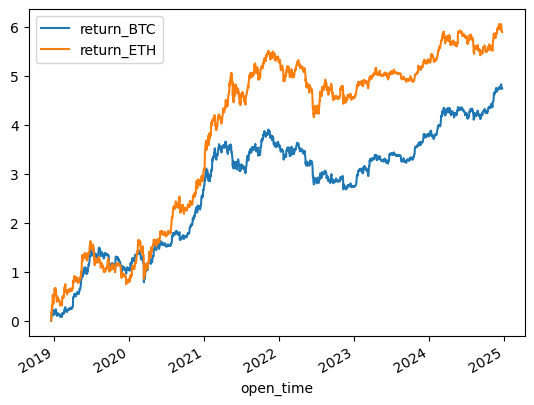

In [4]:
combined_df[['return_BTC', 'return_ETH']].cumsum().plot()

<Axes: xlabel='open_time'>

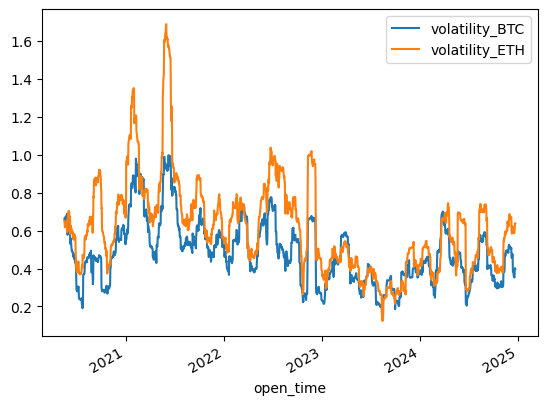

In [5]:
volatility_df.plot()